### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

### Get Data
<ol>
    <li> We get the, previously cleansed, <i>train</i> dataset.
</ol>

In [2]:
X = pd.read_hdf('../wip-data/X_train.h5', key = 'df')
y = pd.read_hdf('../wip-data/y_train.h5', key = 'df')

### Learning Curves
<ol>
    <li> We plot learning curves for the <i>train</i> dataset using an unpenalized logistic regression model. This allows us to gain better insight into the bias-variance tradeoff we are likely to encounter in fitting a logistic regression model and better inform our choice of a appropriate model for the given dataset.
</ol>

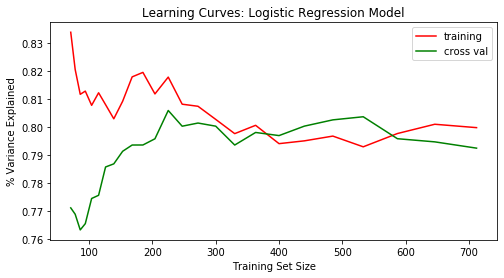

In [3]:
clf = LogisticRegression(max_iter = 1000, random_state = 1970, penalty = 'none')
train_sizes, train_scores, val_scores = learning_curve(clf, X, y, train_sizes = np.logspace(-1, 0, 25),
                                                       shuffle = True, random_state = 1970)

plt.figure(figsize = (8,4))
plt.plot(train_sizes, train_scores.mean(axis = 1), label = 'training', color = 'red')
plt.plot(train_sizes, val_scores.mean(axis = 1), label = 'cross val', color = 'green')
plt.xlabel('Training Set Size')
plt.ylabel('% Variance Explained')
plt.legend()
plt.title('Learning Curves: Logistic Regression Model')
plt.show()

#### Observation
<ol>
    <li> The two learning curves rapidly converge indicating that a Logistic Regression Model using the <i>train</i> dataset is likely to "suffer" from a <i>bias</i> rather than a <i>variance</i> problem.
    <li> The model performance can be improved by either getting more data points (not possible in this case) or increasing the number of features (by developing, say, interaction features) included in the model.
</ol>

### Logistic Regression Models
<ol>
    <li> We use the <i>train-validate</i> strategy to estimate the test error.
    <li> Recall that the learning curves indicate that the quality of the logistic regression model would improve with either additional data or additional features. We introduce new features by adding polynomial and interaction features, built from the original features in the dataset, and use this enhanced feature set to build a new logistic regression model.
    <li> We build 3 models that use different penalty functions - <b>None, L1</b> and <b>L2</b>. For the later two functions, we choose a range of values for the penalty strength parameter.
    <li> We use Gridsearch with 5 fold cross validation to determine the best model using prediction accuracy as the metric.
 </ol>

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 1970)

poly_feat = PolynomialFeatures()
lrc = make_pipeline(poly_feat, clf)

grid = [{'logisticregression__penalty' : ['none']},
        {'logisticregression__penalty' : ['l2'], 'logisticregression__C' : [0.001, 0.1, 1]},
        {'logisticregression__penalty' : ['l1'], 'logisticregression__C' : [0.001, 0.1, 1], 
         'logisticregression__solver' : ['liblinear']}]

grid_search  = GridSearchCV(lrc, param_grid = grid, scoring = 'accuracy')
grid_search.fit(X_train, y_train)
est_test_acc = grid_search.score(X_val, y_val)*100
best_params = grid_search.best_params_

print("The best estimated test set accuracy for the Logistic Regression model = %f" % est_test_acc,"%")
print("The parameters for the best fit Logistic Regression model are: ", best_params)


The best estimated test set accuracy for the Logistic Regression model = 81.564246 %
The parameters for the best fit Logistic Regression model are:  {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2'}


#### Observations
<ol>
    <li> The Ridge penalized model with polynomial and interaction features represents the best model when using the Logistic Regression learning algorithm
 </ol>

### Predictions
<ol>
    <li>We build a logistic regression classifier using the Ridge Penalized algorithm and the parameters identified as providing the best results in the previous step.
    <li>We fit the model to the entire <i>train</i> dataset to obtain the coefficients of the model.
    <li>We use the fitted model to predict for the <i>test</i> dataset.
    <li>Finally, we create the submission file in the required format.

In [6]:
lrc.set_params(**best_params)

X_train, y_train = X, y
X_test = pd.read_hdf('../wip-data/X_test.h5', key = 'df')

lrc.fit(X_train, y_train)
preds = lrc.predict(X_test)[:, np.newaxis]
idx = np.arange(X_train.shape[0]+1, X_train.shape[0]+1+X_test.shape[0])[:, np.newaxis]

columns = ['PassengerId', 'Survived']

dat = np.hstack((idx,preds))
dat = pd.DataFrame(dat, columns = columns)
dat.to_csv('../../data/out_LOGIT.csv', index = False)